In [ ]:
# %% [PATHS & LOGGING — EEGNet]
import sys, logging, warnings
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# ---------- Rutas base (ajusta si tu repo difiere) ----------
PROJ      = Path('..').resolve().parent   # asumiendo este notebook vive en eegnet/
DATA_PROC = PROJ / 'data' / 'processed'

OUT_INTRA = PROJ / 'models' / 'eegnet'
OUT_LOSO  = PROJ / 'models' / 'eegnet' 
OUT_INTER = PROJ / 'models' / 'inter_fixed_eegnet'
for d in (OUT_INTRA, OUT_LOSO, OUT_INTER):
    (d/'figures').mkdir(parents=True, exist_ok=True)
    (d/'tables').mkdir(parents=True, exist_ok=True)
    (d/'logs').mkdir(parents=True, exist_ok=True)

print(f"DATA_PROC: {DATA_PROC}")
print(f"OUT_INTRA: {OUT_INTRA}")
print(f"OUT_LOSO: {OUT_LOSO}") 
print(f"OUT_INTER: {OUT_INTER}")

def _init_logger_eegnet(run_name: str, log_dir):
    """
    Logger para EEGNet - misma estructura que otros modelos
    """
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    log_path = log_dir / 'logs' / f"{ts}_{run_name}.txt"

    logger = logging.getLogger(run_name)
    logger.setLevel(logging.INFO)
    logger.handlers.clear()

    fmt = logging.Formatter("[%(asctime)s] %(levelname)s: %(message)s", datefmt="%H:%M:%S")
    ch = logging.StreamHandler(stream=sys.stdout); ch.setLevel(logging.INFO); ch.setFormatter(fmt)
    fh = logging.FileHandler(log_path, encoding="utf-8"); fh.setLevel(logging.INFO); fh.setFormatter(fmt)
    logger.addHandler(ch); logger.addHandler(fh)

    # Silenciar ruido
    import mne
    mne.set_log_level("ERROR")
    warnings.filterwarnings("ignore", category=UserWarning, module="mne")
    warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")
    warnings.filterwarnings("ignore", category=UserWarning, module="braindecode")
    
    return logger, log_path

In [ ]:
# %% [HELPERS & EEGNet MODEL - VERSIÓN BRAINDECODE 1.2]
import torch
import torch.nn as nn
from braindecode.models import EEGNet
from braindecode import EEGClassifier
from skorch.callbacks import EarlyStopping, EpochScoring, LRScheduler
from braindecode.datasets import create_from_X_y
from skorch.helper import predefined_split
import numpy as np
import mne
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Configuración basada en ejemplos oficiales
EEGNET_CONFIG = {
    'n_chans': 8,
    'n_outputs': 4,
    'input_window_seconds': 4.0,
    'sfreq': 160,
    'drop_prob': 0.5,
    'kernel_length': 64,
    'F1': 8,
    'D': 2,
    'F2': 16,
}

def _discover_subject_ids(fif_dir=DATA_PROC, pattern='S???_MI-epo.fif'):
    """Descubre sujetos disponibles"""
    files = sorted(glob(str(fif_dir / pattern)))
    return [Path(f).stem.split('_')[0] for f in files]

def _epochs_to_Xy(epochs: mne.Epochs):
    """Convierte epochs a X, y"""
    X = epochs.get_data()
    inv = {v: k for k, v in epochs.event_id.items()}
    y = np.array([inv[e[-1]] for e in epochs.events], dtype=object)
    return X, y

def prepare_data_for_eegnet(epochs, crop_window=(0.5, 4.5), sfreq=160):
    """
    Prepara datos de MNE para EEGNet
    """
    epochs_cropped = epochs.copy().crop(*crop_window)
    X = epochs_cropped.get_data().astype(np.float32)
    
    target_samples = int((crop_window[1] - crop_window[0]) * sfreq)
    if X.shape[2] > target_samples:
        X = X[:, :, :target_samples]
    elif X.shape[2] < target_samples:
        pad_width = target_samples - X.shape[2]
        X = np.pad(X, ((0, 0), (0, 0), (0, pad_width)), mode='constant')
    
    _, y = _epochs_to_Xy(epochs_cropped)
    
    return X, y

def create_eegnet_classifier(n_chans=8, n_classes=4, input_window_seconds=4.0, sfreq=160, 
                           drop_prob=0.5, max_epochs=150):
    """
    Crea clasificador EEGNet según documentación Braindecode 1.2
    """
    model = EEGNet(
        n_chans=n_chans,
        n_outputs=n_classes,
        input_window_seconds=input_window_seconds,
        sfreq=sfreq,
        drop_prob=drop_prob,
        kernel_length=64,
        F1=8,
        D=2,
        F2=16,
        final_conv_length='auto'
    )
    
    # Callbacks según documentación oficial
    callbacks = [
        ('early_stopping', EarlyStopping(patience=10)),
        ('accuracy', EpochScoring(
            'accuracy', 
            on_train=False, 
            name='valid_acc',
            lower_is_better=False
        )),
    ]
    
    classifier = EEGClassifier(
        model,
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=0.0005,  # Learning rate de los ejemplos oficiales
        batch_size=64,  # Batch size más grande como en ejemplos
        max_epochs=max_epochs,
        train_split=None,  # IMPORTANTE: No usar validation split automático
        callbacks=callbacks,
        iterator_train__shuffle=True,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=1
    )
    
    return classifier

In [ ]:
# %% [INTRA-SUBJECT - Versión Simplificada]
def run_intra_all_eegnet_simple(
    fif_dir=DATA_PROC,
    k=5,
    random_state=42,
    crop_window=(0.5, 4.5),
    n_chans=8,
    input_window_seconds=4.0,
    sfreq=160,
    drop_prob=0.5,
    max_epochs=150,
    save_txt_name=None,
    save_csv_name=None
):
    """
    INTRA-subject para EEGNet - Versión simplificada según documentación
    """
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_tag = f"eegnet_intra_simple_{ts}"
    logger, log_path = _init_logger_eegnet(run_name=run_tag, log_dir=OUT_INTRA)

    subject_ids = _discover_subject_ids(fif_dir)
    if not subject_ids:
        logger.error("No se encontraron sujetos")
        return None

    logger.info(f"[RUN {run_tag}] EEGNet INTRA Simple | k={k}")
    logger.info(f"Sujetos: {len(subject_ids)}")

    rows = []

    for subject_id in subject_ids[:3]:  # Solo primeros 3 para prueba
        fif_path = fif_dir / f"{subject_id}_MI-epo.fif"
        epochs = mne.read_epochs(fif_path, preload=True, verbose=False)
        
        X, y_str = prepare_data_for_eegnet(epochs, crop_window, sfreq)
        le = LabelEncoder()
        y = le.fit_transform(y_str)
        classes = list(le.classes_)

        logger.info(f"Procesando {subject_id} | epochs={len(y)} | clases={classes}")

        # K-fold simple
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
        accs, f1s = [], []

        for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y), start=1):
            X_tr, X_te = X[tr_idx], X[te_idx]
            y_tr, y_te = y[tr_idx], y[te_idx]

            # Modelo según documentación oficial
            classifier = create_eegnet_classifier(
                n_chans=n_chans,
                n_classes=len(classes),
                input_window_seconds=input_window_seconds,
                sfreq=sfreq,
                drop_prob=drop_prob,
                max_epochs=max_epochs
            )
            
            try:
                logger.info(f"[{subject_id} | fold {fold}] Entrenando...")
                classifier.fit(X_tr, y_tr)
                y_pred = classifier.predict(X_te)
                
                acc = accuracy_score(y_te, y_pred)
                f1m = f1_score(y_te, y_pred, average='macro')
                
                accs.append(acc)
                f1s.append(f1m)
                logger.info(f"[{subject_id} | fold {fold}] acc={acc:.3f} | f1={f1m:.3f}")
                
            except Exception as e:
                logger.error(f"Error en fold {fold}: {e}")
                continue

        if accs:
            acc_mu, acc_sd = float(np.mean(accs)), float(np.std(accs))
            f1_mu, f1_sd = float(np.mean(f1s)), float(np.std(f1s))
            
            logger.info(f"[{subject_id}] ACC={acc_mu:.3f}±{acc_sd:.3f} | F1={f1_mu:.3f}±{f1_sd:.3f}")
            
            rows.append({
                'subject': subject_id,
                'acc_mean': acc_mu,
                'acc_std': acc_sd,
                'f1_mean': f1_mu,
                'f1_std': f1_sd,
                'n_epochs': len(y),
                'n_classes': len(classes)
            })

    if rows:
        df = pd.DataFrame(rows)
        out_csv = OUT_INTRA / 'tables' / f"eegnet_intra_simple_{ts}.csv"
        df.to_csv(out_csv, index=False)
        logger.info(f"Resultados guardados en: {out_csv}")
        return df
    else:
        logger.error("No se generaron resultados")
        return None

# Ejecutar versión simple
df_simple = run_intra_all_eegnet_simple(max_epochs=50)  # Pocas épocas para prueba

In [ ]:
# %% [LOSO — EEGNet Leave-One-Subject-Out Mejorado]
def run_loso_all_eegnet_improved(
    fif_dir=DATA_PROC,
    crop_window=(0.5, 4.5),
    n_chans=8,
    input_window_seconds=4.0,
    sfreq=160,
    drop_prob=0.5,
    max_epochs=100,
    calibrate_k_per_class=None,
    max_subplots_per_fig=12,
    n_cols=4,
    save_txt_name=None,
    save_csv_name=None
):
    """
    LOSO para EEGNet - versión mejorada
    """
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_tag = f"eegnet_loso_all_improved_{ts}"
    logger, log_path = _init_logger_eegnet(run_name=run_tag, log_dir=OUT_LOSO)

    subject_ids = _discover_subject_ids(fif_dir)
    if not subject_ids:
        logger.error("No se encontraron sujetos")
        return None

    logger.info(f"[RUN {run_tag}] EEGNet LOSO MEJORADO | crop={crop_window}")
    logger.info(f"Configuración: {EEGNET_CONFIG_OPTIMIZED}")
    logger.info(f"Sujetos: {subject_ids}")

    # Cargar todos los datos
    epochs_dict = {}
    for sid in subject_ids:
        try:
            epochs = mne.read_epochs(str(fif_dir / f"{sid}_MI-epo.fif"), preload=True, verbose=False)
            epochs_dict[sid] = epochs
        except Exception as e:
            logger.warning(f"Error cargando {sid}: {e}")

    classes_global, cm_global = None, None
    rows, cm_items = [], []

    for test_subject in subject_ids:
        if test_subject not in epochs_dict:
            continue

        # Preparar test subject
        ep_test = epochs_dict[test_subject]
        X_test, y_test_str = prepare_data_for_eegnet(ep_test, crop_window, sfreq)
        
        # Train subjects
        train_subjects = [sid for sid in subject_ids if sid != test_subject and sid in epochs_dict]
        if not train_subjects:
            logger.warning(f"No hay sujetos train para {test_subject}")
            continue

        # Concatenar train subjects
        X_train_list, y_train_list = [], []
        for train_sid in train_subjects:
            X_tr, y_tr_str = prepare_data_for_eegnet(epochs_dict[train_sid], crop_window, sfreq)
            X_train_list.append(X_tr)
            y_train_list.append(y_tr_str)

        X_train = np.concatenate(X_train_list, axis=0)
        y_train_str = np.concatenate(y_train_list, axis=0)

        # Codificar labels
        le = LabelEncoder()
        le.fit(np.concatenate([y_train_str, y_test_str]))
        y_train = le.transform(y_train_str)
        y_test = le.transform(y_test_str)
        classes = list(le.classes_)

        if classes_global is None:
            classes_global = classes
            cm_global = np.zeros((len(classes), len(classes)), dtype=int)

        # Split para validation del training
        split_idx = int(0.8 * len(X_train))
        X_tr_final, X_val = X_train[:split_idx], X_train[split_idx:]
        y_tr_final, y_val = y_train[:split_idx], y_train[split_idx:]

        # Entrenar EEGNet MEJORADO
        classifier = create_eegnet_classifier_improved(
            n_chans=n_chans,
            n_classes=len(classes),
            input_window_seconds=input_window_seconds,
            sfreq=sfreq,
            drop_prob=drop_prob,
            X_val=X_val,
            y_val=y_val,
            max_epochs=max_epochs
        )

        try:
            logger.info(f"[LOSO] Entrenando para test subject: {test_subject}")
            classifier.fit(X_tr_final, y_tr_final)
            y_pred = classifier.predict(X_test)
            
            acc = accuracy_score(y_test, y_pred)
            f1m = f1_score(y_test, y_pred, average='macro')
            bal_acc = accuracy_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(classes)))
            cm_global += cm

            logger.info(f"[LOSO MEJORADO] test={test_subject} | acc={acc:.3f} | f1m={f1m:.3f} | bal_acc={bal_acc:.3f} | n_test={len(y_test)}")

            rows.append(dict(
                test_subject=test_subject,
                acc=float(acc),
                f1_macro=float(f1m),
                bal_acc=float(bal_acc),
                n_test=int(len(y_test)),
                n_train=len(train_subjects),
                crop=str(crop_window),
                n_chans=n_chans,
                input_window_seconds=input_window_seconds,
                sfreq=sfreq,
                drop_prob=drop_prob
            ))
            cm_items.append((test_subject, cm, classes))

        except Exception as e:
            logger.error(f"Error en {test_subject}: {e}")
            import traceback
            logger.error(traceback.format_exc())
            continue

    # Procesar resultados
    if not rows:
        logger.error("No se generaron resultados LOSO")
        return None

    # Fila GLOBAL
    acc_mu = float(np.mean([r['acc'] for r in rows]))
    f1_mu = float(np.mean([r['f1_macro'] for r in rows]))
    bal_acc_mu = float(np.mean([r['bal_acc'] for r in rows]))
    
    rows.append(dict(
        test_subject="GLOBAL",
        acc=acc_mu,
        f1_macro=f1_mu,
        bal_acc=bal_acc_mu,
        n_test=int(np.sum([r['n_test'] for r in rows])),
        n_train=int(np.mean([r['n_train'] for r in rows])),
        crop=str(crop_window),
        n_chans=n_chans,
        input_window_seconds=input_window_seconds,
        sfreq=sfreq,
        drop_prob=drop_prob
    ))

    df_rows = pd.DataFrame(rows).sort_values('test_subject')
    
    # Guardar resultados
    out_csv = (OUT_LOSO / 'tables' / f"{ts}_{save_csv_name}") if save_csv_name else (OUT_LOSO / 'tables' / f"eegnet_metrics_loso_all_improved_{ts}.csv")
    df_rows.to_csv(out_csv, index=False)
    
    out_txt = (OUT_LOSO / 'logs' / f"{ts}_{save_txt_name}") if save_txt_name else (OUT_LOSO / 'logs' / f"eegnet_metrics_loso_all_improved_{ts}.txt")
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write(f"EEGNet LOSO MEJORADO — Métricas por sujeto\n")
        f.write(f"Generado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Configuración: {EEGNET_CONFIG_OPTIMIZED}\n\n")
        header = df_rows.columns.tolist()
        f.write(" | ".join(header) + "\n")
        f.write("-" * 120 + "\n")
        for _, r in df_rows.iterrows():
            vals = []
            for k in header:
                v = r[k]
                if isinstance(v, float):
                    vals.append(f"{v:.4f}")
                else:
                    vals.append(str(v))
            f.write(" | ".join(vals) + "\n")

    # Matrices de confusión
    if cm_items:
        n = len(cm_items)
        per_fig = max(1, int(max_subplots_per_fig))
        n_figs = ceil(n / per_fig)
        n_rows_needed = lambda count: ceil(count / n_cols)

        for fig_idx in range(n_figs):
            start = fig_idx * per_fig
            end = min((fig_idx + 1) * per_fig, n)
            chunk = cm_items[start:end]
            count = len(chunk)
            n_rows = n_rows_needed(count)

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.8 * n_rows), dpi=140)
            axes = np.atleast_2d(axes).flatten()

            for ax_i, (sid, cm_sum, classes) in enumerate(chunk):
                ax = axes[ax_i]
                disp = ConfusionMatrixDisplay(cm_sum, display_labels=classes)
                disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format='d')
                ax.set_title(f"{sid}")
                ax.set_xlabel("")
                ax.set_ylabel("")

            for j in range(ax_i + 1, len(axes)):
                axes[j].axis("off")

            out_png = OUT_LOSO / 'figures' / f"eegnet_loso_confusions_improved_{ts}_p{fig_idx+1}.png"
            fig.suptitle(f"EEGNet LOSO MEJORADO — Matrices de confusión (página {fig_idx+1}/{n_figs})", y=0.995, fontsize=14)
            fig.tight_layout(rect=[0, 0, 1, 0.97])
            fig.savefig(out_png)
            plt.close(fig)
            logger.info(f"Figura → {out_png}")

    logger.info(f"Log completo → {log_path}")
    print(f"[GLOBAL EEGNet-LOSO MEJORADO] ACC={acc_mu:.3f} | F1m={f1_mu:.3f} | Bal_ACC={bal_acc_mu:.3f}")
    
    return df_rows

In [ ]:
# %% [INTER-SUBJECT — EEGNet con TEST fijo Mejorado]
from sklearn.model_selection import train_test_split

# Mismos sujetos TEST que en otros modelos
FIXED_TEST_SUBJECTS = [
    'S007','S025','S029','S031','S032','S034','S035','S042','S043','S049','S056','S058','S062','S072',
    'S001','S010','S013','S017','S019','S030', 
    'S005','S006','S009','S097'
]

def run_inter_fixed_eegnet_improved(
    fif_dir=DATA_PROC,
    crop_window=(0.5, 4.5),
    n_chans=8,
    input_window_seconds=4.0,
    sfreq=160,
    drop_prob=0.5,
    val_size=16,
    random_state=42,
    max_epochs=100,
    save_txt_name=None,
    save_csv_name=None
):
    """
    INTER-subject con TEST fijo - versión mejorada
    """
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_tag = f"eegnet_inter_fixed_improved_{ts}"
    logger, log_path = _init_logger_eegnet(run_name=run_tag, log_dir=OUT_INTER)

    # Split de sujetos (igual que otros modelos)
    all_subjects = _discover_subject_ids(fif_dir)
    existing_test = [s for s in FIXED_TEST_SUBJECTS if s in all_subjects]
    remaining = [s for s in all_subjects if s not in existing_test]
    
    train_subjects, val_subjects = train_test_split(
        remaining, test_size=val_size, random_state=random_state
    )
    
    logger.info(f"Configuración: {EEGNET_CONFIG_OPTIMIZED}")
    logger.info(f"TRAIN={len(train_subjects)} | VAL={len(val_subjects)} | TEST={len(existing_test)}")
    logger.info(f"Train: {train_subjects[:5]}...")
    logger.info(f"Val: {val_subjects}")
    logger.info(f"Test: {existing_test}")

    # Cargar y preparar datos
    def load_subjects_data(subjects_list):
        X_list, y_list = [], []
        for sid in subjects_list:
            try:
                epochs = mne.read_epochs(str(fif_dir / f"{sid}_MI-epo.fif"), preload=True, verbose=False)
                X, y = prepare_data_for_eegnet(epochs, crop_window, sfreq)
                X_list.append(X)
                y_list.append(y)
            except Exception as e:
                logger.warning(f"Error cargando {sid}: {e}")
        if X_list:
            return np.concatenate(X_list), np.concatenate(y_list)
        else:
            return np.array([]), np.array([])

    X_train, y_train_str = load_subjects_data(train_subjects)
    X_val, y_val_str = load_subjects_data(val_subjects)
    X_test, y_test_str = load_subjects_data(existing_test)

    # Verificar que hay datos
    if len(X_train) == 0 or len(X_test) == 0:
        logger.error("No hay datos suficientes para entrenar o testear")
        return None

    # Codificar labels
    le = LabelEncoder()
    le.fit(np.concatenate([y_train_str, y_val_str, y_test_str]))
    y_train = le.transform(y_train_str)
    y_val = le.transform(y_val_str)
    y_test = le.transform(y_test_str)
    classes = list(le.classes_)

    logger.info(f"Datos: TRAIN={X_train.shape} | VAL={X_val.shape} | TEST={X_test.shape}")
    logger.info(f"Clases: {classes}")

    # Entrenar modelo MEJORADO en TRAIN
    classifier = create_eegnet_classifier_improved(
        n_chans=n_chans,
        n_classes=len(classes),
        input_window_seconds=input_window_seconds,
        sfreq=sfreq,
        drop_prob=drop_prob,
        X_val=X_val,
        y_val=y_val,
        max_epochs=max_epochs
    )

    try:
        # Entrenamiento
        logger.info("Entrenando EEGNet INTER...")
        classifier.fit(X_train, y_train)

        # Validation
        y_val_pred = classifier.predict(X_val)
        acc_val = accuracy_score(y_val, y_val_pred)
        f1_val = f1_score(y_val, y_val_pred, average='macro')
        bal_acc_val = accuracy_score(y_val, y_val_pred)

        # Test
        y_test_pred = classifier.predict(X_test)
        acc_test = accuracy_score(y_test, y_test_pred)
        f1_test = f1_score(y_test, y_test_pred, average='macro')
        bal_acc_test = accuracy_score(y_test, y_test_pred)

        logger.info(f"[VAL] ACC={acc_val:.3f} | F1m={f1_val:.3f} | Bal_ACC={bal_acc_val:.3f}")
        logger.info(f"[TEST] ACC={acc_test:.3f} | F1m={f1_test:.3f} | Bal_ACC={bal_acc_test:.3f}")

        # Matriz de confusión TEST
        cm_test = confusion_matrix(y_test, y_test_pred, labels=np.arange(len(classes)))
        fig, ax = plt.subplots(figsize=(6, 5), dpi=140)
        ConfusionMatrixDisplay(cm_test, display_labels=classes).plot(ax=ax, cmap="Blues", values_format='d')
        ax.set_title(f"EEGNet INTER MEJORADO — Test Fixed\nACC={acc_test:.3f}, F1={f1_test:.3f}")
        fig.tight_layout()
        out_png = OUT_INTER / 'figures' / f"eegnet_inter_confusion_improved_{ts}.png"
        fig.savefig(out_png)
        plt.close(fig)

        # Guardar resultados
        df = pd.DataFrame([dict(
            mode="eegnet_inter_fixed_improved",
            acc_val=float(acc_val),
            f1_val=float(f1_val),
            bal_acc_val=float(bal_acc_val),
            acc_test=float(acc_test),
            f1_test=float(f1_test),
            bal_acc_test=float(bal_acc_test),
            n_train=len(train_subjects),
            n_val=len(val_subjects),
            n_test=len(existing_test),
            crop=str(crop_window),
            n_chans=n_chans,
            input_window_seconds=input_window_seconds,
            sfreq=sfreq,
            drop_prob=drop_prob,
            train_subjects=",".join(sorted(train_subjects)),
            val_subjects=",".join(sorted(val_subjects)),
            test_subjects=",".join(sorted(existing_test))
        )])

        out_csv = (OUT_INTER / 'tables' / f"{ts}_{save_csv_name}") if save_csv_name else (OUT_INTER / 'tables' / f"eegnet_inter_fixed_improved_{ts}.csv")
        df.to_csv(out_csv, index=False)

        out_txt = (OUT_INTER / 'logs' / f"{ts}_{save_txt_name}") if save_txt_name else (OUT_INTER / 'logs' / f"eegnet_inter_fixed_improved_{ts}.txt")
        with open(out_txt, "w", encoding="utf-8") as f:
            f.write("EEGNet INTER MEJORADO — TEST fijo\n")
            f.write(f"Generado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Configuración: {EEGNET_CONFIG_OPTIMIZED}\n\n")
            f.write(df.to_string(index=False))

        logger.info(f"CSV → {out_csv}")
        logger.info(f"TXT → {out_txt}")
        logger.info(f"Confusion matrix → {out_png}")
        logger.info(f"Log completo → {log_path}")

        return df

    except Exception as e:
        logger.error(f"Error en entrenamiento INTER: {e}")
        import traceback
        logger.error(traceback.format_exc())
        return None

# DEBUG

In [4]:
# %% [ANÁLISIS COMPLETO SUJETO S001]
def analyze_subject_s001():
    """Análisis detallado del sujeto S001"""
    subject_id = "S065"
    fif_path = DATA_PROC / f"{subject_id}_MI-epo.fif"
    
    print("=== ANÁLISIS DETALLADO SUJETO S001 ===")
    
    # Cargar epochs
    epochs = mne.read_epochs(fif_path, preload=True, verbose=False)
    
    print("1. INFORMACIÓN BÁSICA:")
    print(f"   - Número de épocas: {len(epochs)}")
    print(f"   - Canales: {epochs.ch_names}")
    print(f"   - Tiempo: {epochs.times[0]:.1f} a {epochs.times[-1]:.1f} s")
    print(f"   - Frecuencia de muestreo: {epochs.info['sfreq']} Hz")
    
    print("\n2. EVENTOS Y CLASES:")
    print(f"   - Event IDs: {epochs.event_id}")
    events, event_id = epochs.events, epochs.event_id
    for event_name, event_id_val in event_id.items():
        count = np.sum(events[:, -1] == event_id_val)
        print(f"   - {event_name}: {count} épocas")
    
    print("\n3. ESTADÍSTICAS DE DATOS:")
    data = epochs.get_data()
    print(f"   - Shape: {data.shape}")
    print(f"   - Rango global: [{data.min():.8f}, {data.max():.8f}]")
    print(f"   - Media global: {data.mean():.8f}")
    print(f"   - Desviación global: {data.std():.8f}")
    
    # Estadísticas por canal
    print("\n4. ESTADÍSTICAS POR CANAL:")
    for i, ch_name in enumerate(epochs.ch_names):
        ch_data = data[:, i, :]
        print(f"   - {ch_name}: mean={ch_data.mean():.8f}, std={ch_data.std():.8f}")
    
    # Estadísticas por clase
    print("\n5. ESTADÍSTICAS POR CLASE:")
    for event_name, event_id_val in event_id.items():
        class_data = data[events[:, -1] == event_id_val]
        print(f"   - {event_name}: mean={class_data.mean():.8f}, std={class_data.std():.8f}")
    
    # Verificar balance
    print("\n6. BALANCE DE CLASES:")
    total_epochs = len(epochs)
    for event_name, event_id_val in event_id.items():
        count = np.sum(events[:, -1] == event_id_val)
        percentage = (count / total_epochs) * 100
        print(f"   - {event_name}: {count} épocas ({percentage:.1f}%)")
    
    return epochs

# Ejecutar análisis
epochs_s001 = analyze_subject_s001()

=== ANÁLISIS DETALLADO SUJETO S001 ===
1. INFORMACIÓN BÁSICA:
   - Número de épocas: 90
   - Canales: ['C3', 'C4', 'Cz', 'CP3', 'CP4', 'FC3', 'FC4', 'CPz']
   - Tiempo: 0.5 a 4.5 s
   - Frecuencia de muestreo: 160.0 Hz

2. EVENTOS Y CLASES:
   - Event IDs: {'Left': 1, 'Right': 2, 'Both Fists': 3, 'Both Feet': 4}
   - Left: 24 épocas
   - Right: 21 épocas
   - Both Fists: 22 épocas
   - Both Feet: 23 épocas

3. ESTADÍSTICAS DE DATOS:
   - Shape: (90, 8, 641)
   - Rango global: [-0.00006557, 0.00005621]
   - Media global: -0.00000000
   - Desviación global: 0.00000838

4. ESTADÍSTICAS POR CANAL:
   - C3: mean=-0.00000000, std=0.00000758
   - C4: mean=-0.00000000, std=0.00000860
   - Cz: mean=-0.00000000, std=0.00000860
   - CP3: mean=-0.00000000, std=0.00000780
   - CP4: mean=0.00000000, std=0.00000835
   - FC3: mean=-0.00000000, std=0.00000918
   - FC4: mean=-0.00000000, std=0.00000895
   - CPz: mean=-0.00000000, std=0.00000780

5. ESTADÍSTICAS POR CLASE:
   - Left: mean=-0.00000000, st

=== VISUALIZACIÓN DE DATOS ===


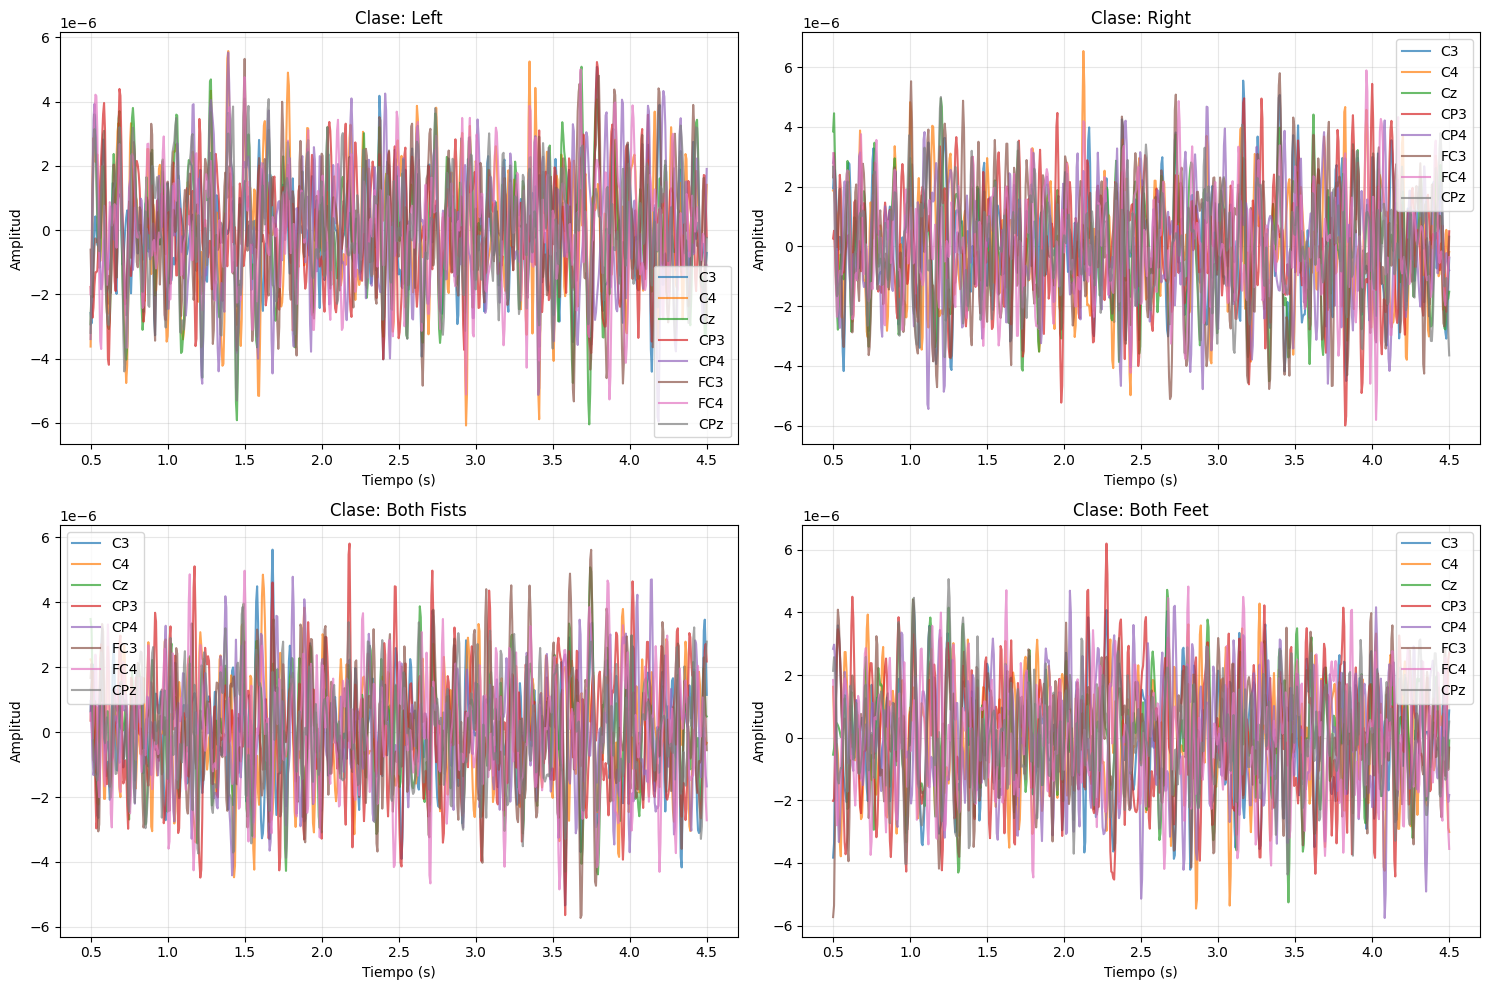

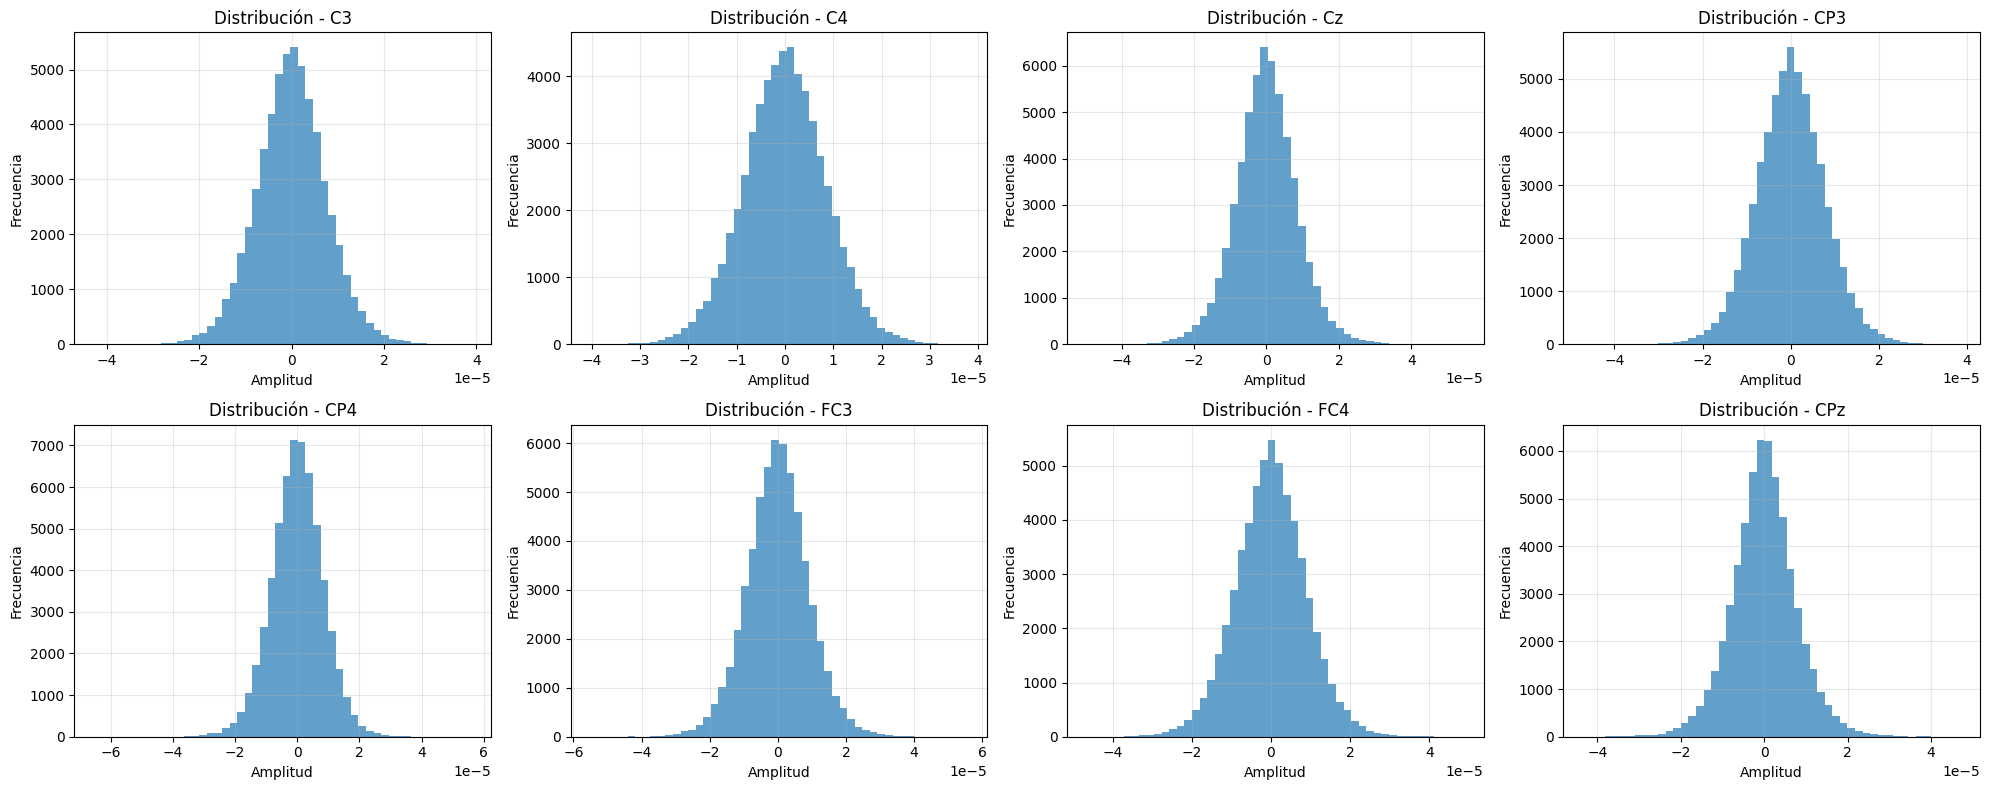

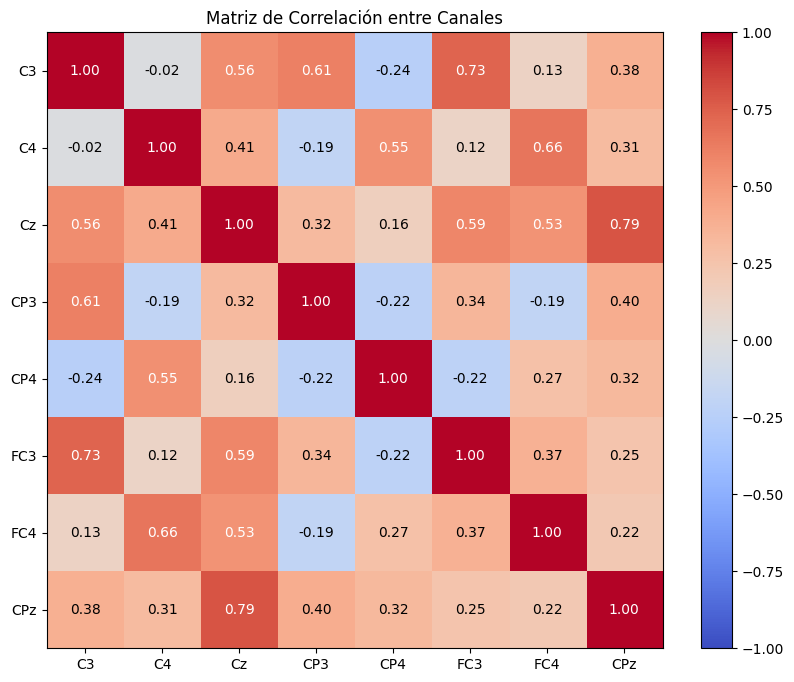

In [5]:
# %% [VISUALIZACIÓN DE DATOS]
def visualize_subject_data(epochs):
    """Visualizar datos del sujeto"""
    import matplotlib.pyplot as plt
    
    print("=== VISUALIZACIÓN DE DATOS ===")
    
    # 1. Promedio por clase
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (event_name, event_id_val) in enumerate(epochs.event_id.items()):
        # Seleccionar épocas de esta clase
        class_epochs = epochs[event_name]
        # Promedio a través de épocas
        class_data = class_epochs.get_data().mean(axis=0)
        
        # Plot cada canal
        for ch in range(class_data.shape[0]):
            axes[i].plot(class_epochs.times, class_data[ch], label=epochs.ch_names[ch], alpha=0.7)
        
        axes[i].set_title(f'Clase: {event_name}')
        axes[i].set_xlabel('Tiempo (s)')
        axes[i].set_ylabel('Amplitud')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Distribución de amplitudes
    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    axes = axes.flatten()
    
    data = epochs.get_data()
    for i, ch_name in enumerate(epochs.ch_names):
        ch_data = data[:, i, :].flatten()
        axes[i].hist(ch_data, bins=50, alpha=0.7)
        axes[i].set_title(f'Distribución - {ch_name}')
        axes[i].set_xlabel('Amplitud')
        axes[i].set_ylabel('Frecuencia')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Matriz de correlación entre canales
    from scipy.stats import pearsonr
    
    data = epochs.get_data()
    n_channels = data.shape[1]
    corr_matrix = np.zeros((n_channels, n_channels))
    
    for i in range(n_channels):
        for j in range(n_channels):
            corr, _ = pearsonr(data[:, i, :].flatten(), data[:, j, :].flatten())
            corr_matrix[i, j] = corr
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_xticks(range(n_channels))
    ax.set_yticks(range(n_channels))
    ax.set_xticklabels(epochs.ch_names)
    ax.set_yticklabels(epochs.ch_names)
    ax.set_title('Matriz de Correlación entre Canales')
    
    # Añadir valores
    for i in range(n_channels):
        for j in range(n_channels):
            ax.text(j, i, f'{corr_matrix[i, j]:.2f}', 
                   ha='center', va='center', color='black' if abs(corr_matrix[i, j]) < 0.5 else 'white')
    
    plt.colorbar(im)
    plt.show()

# Ejecutar visualización
visualize_subject_data(epochs_s001)

In [6]:
# %% [VERIFICACIÓN DE DATOS ORIGINALES]
def check_original_data():
    """Verificar cómo son los datos originales"""
    subject_id = "S065"
    fif_path = DATA_PROC / f"{subject_id}_MI-epo.fif"
    epochs = mne.read_epochs(fif_path, preload=True, verbose=False)
    
    # Datos SIN normalizar
    X_original, y_str = prepare_data_for_eegnet(epochs, (0.5, 4.5), 160)
    
    print("=== VERIFICACIÓN DE DATOS ORIGINALES ===")
    print(f"Shape: {X_original.shape}")
    print(f"Rango original: [{X_original.min():.6f}, {X_original.max():.6f}]")
    print(f"Media original: {X_original.mean():.6f}")
    print(f"Desviación original: {X_original.std():.6f}")
    
    # Ver un canal específico
    print(f"\nEjemplo - Canal 0, Época 0:")
    print(f"Valores: {X_original[0, 0, :10]}...")  # Primeros 10 valores
    print(f"Stats - Min: {X_original[0, 0].min():.6f}, Max: {X_original[0, 0].max():.6f}")
    
    # Ver si hay problemas de escala
    if np.abs(X_original.mean()) < 1e-6 and X_original.std() < 1e-6:
        print("❌ ¡PROBLEMA: Los datos podrían estar en una escala incorrecta!")
    else:
        print("✅ Escala de datos parece correcta")

check_original_data()

=== VERIFICACIÓN DE DATOS ORIGINALES ===
Shape: (90, 8, 640)
Rango original: [-0.000066, 0.000056]
Media original: -0.000000
Desviación original: 0.000008

Ejemplo - Canal 0, Época 0:
Valores: [ 7.5926264e-06  8.0176314e-06  6.2557565e-06  2.9341973e-06
 -4.6383164e-07 -1.8744961e-06 -5.6089402e-07  1.7770062e-06
  2.6102953e-06  1.1055013e-06]...
Stats - Min: -0.000026, Max: 0.000020
✅ Escala de datos parece correcta


In [7]:
# %% [NORMALIZACIÓN DE DATOS]
def prepare_data_for_eegnet_normalized(epochs, crop_window=(0.5, 4.5), sfreq=160):
    """
    Prepara datos con NORMALIZACIÓN - esencial para redes neuronales
    """
    epochs_cropped = epochs.copy().crop(*crop_window)
    X = epochs_cropped.get_data().astype(np.float32)
    
    # NORMALIZACIÓN POR CANAL Y POR EPOCA
    for i in range(X.shape[0]):  # Por cada época
        for j in range(X.shape[1]):  # Por cada canal
            channel_data = X[i, j]
            # Normalizar a media 0, desviación 1
            X[i, j] = (channel_data - np.mean(channel_data)) / (np.std(channel_data) + 1e-8)
    
    # Asegurar longitud consistente
    target_samples = int((crop_window[1] - crop_window[0]) * sfreq)
    if X.shape[2] > target_samples:
        X = X[:, :, :target_samples]
    elif X.shape[2] < target_samples:
        pad_width = target_samples - X.shape[2]
        X = np.pad(X, ((0, 0), (0, 0), (0, pad_width)), mode='constant')
    
    _, y = _epochs_to_Xy(epochs_cropped)
    
    print(f"✅ Datos normalizados - Rango: [{X.min():.6f}, {X.max():.6f}]")
    return X, y

In [8]:
# %% [OPTIMIZACIÓN SISTEMÁTICA DE HIPERPARÁMETROS]
def optimize_hyperparameters_single_subject():
    """Optimización sistemática para un solo sujeto"""
    subject_id = "S065"
    fif_path = DATA_PROC / f"{subject_id}_MI-epo.fif"
    epochs = mne.read_epochs(fif_path, preload=True, verbose=False)
    
    # Preparar datos (con normalización)
    X, y_str = prepare_data_for_eegnet_normalized(epochs, (0.5, 4.5), 160)
    le = LabelEncoder()
    y = le.fit_transform(y_str)
    classes = list(le.classes_)
    
    print("=== OPTIMIZACIÓN SISTEMÁTICA DE HIPERPARÁMETROS ===")
    print(f"Sujeto: {subject_id}")
    print(f"Clases: {classes}")
    print(f"Datos: {X.shape}")
    
    # Split train-test
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Configuraciones a probar
    configs = [
        # Configuración 1: Baseline
        {
            'name': 'Baseline',
            'F1': 8, 'F2': 16, 'kernel_length': 64,
            'drop_prob': 0.5, 'lr': 0.0005, 'batch_size': 32
        },
        # Configuración 2: Más capacidad
        {
            'name': 'Más Filtros',
            'F1': 16, 'F2': 32, 'kernel_length': 64,
            'drop_prob': 0.5, 'lr': 0.0005, 'batch_size': 32
        },
        # Configuración 3: Kernel más pequeño
        {
            'name': 'Kernel Pequeño',
            'F1': 8, 'F2': 16, 'kernel_length': 32,
            'drop_prob': 0.5, 'lr': 0.0005, 'batch_size': 32
        },
        # Configuración 4: Más regularización
        {
            'name': 'Más Regularización',
            'F1': 8, 'F2': 16, 'kernel_length': 64,
            'drop_prob': 0.7, 'lr': 0.0005, 'batch_size': 32
        },
        # Configuración 5: Learning rate más alto
        {
            'name': 'LR Alto',
            'F1': 8, 'F2': 16, 'kernel_length': 64,
            'drop_prob': 0.5, 'lr': 0.001, 'batch_size': 32
        },
        # Configuración 6: Batch pequeño
        {
            'name': 'Batch Pequeño',
            'F1': 8, 'F2': 16, 'kernel_length': 64,
            'drop_prob': 0.5, 'lr': 0.0005, 'batch_size': 16
        },
    ]
    
    results = []
    
    for config in configs:
        print(f"\n--- Probando: {config['name']} ---")
        print(f"   F1: {config['F1']}, F2: {config['F2']}, Kernel: {config['kernel_length']}")
        print(f"   Dropout: {config['drop_prob']}, LR: {config['lr']}, Batch: {config['batch_size']}")
        
        try:
            model = EEGNet(
                n_chans=8,
                n_outputs=4,
                input_window_seconds=4.0,
                sfreq=160,
                drop_prob=config['drop_prob'],
                kernel_length=config['kernel_length'],
                F1=config['F1'],
                D=2,
                F2=config['F2'],
            )
            
            classifier = EEGClassifier(
                model,
                criterion=nn.CrossEntropyLoss,
                optimizer=torch.optim.AdamW,
                optimizer__lr=config['lr'],
                optimizer__weight_decay=0.001,
                batch_size=config['batch_size'],
                max_epochs=80,
                train_split=None,
                callbacks=[],
                iterator_train__shuffle=True,
                device='cuda' if torch.cuda.is_available() else 'cpu',
                verbose=0
            )
            
            # Entrenar
            classifier.fit(X_train, y_train)
            
            # Evaluar
            y_pred = classifier.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='macro')
            
            # Obtener loss final
            final_loss = classifier.history[-1, 'train_loss']
            
            print(f"   ✅ Resultados: Acc={acc:.3f}, F1={f1:.3f}, Loss={final_loss:.3f}")
            
            results.append({
                'config': config['name'],
                'accuracy': acc,
                'f1_score': f1,
                'final_loss': final_loss,
                'params': config
            })
            
        except Exception as e:
            print(f"   ❌ Error: {e}")
            continue
    
    # Mostrar mejores resultados
    print(f"\n=== RESUMEN DE RESULTADOS ===")
    results_sorted = sorted(results, key=lambda x: x['accuracy'], reverse=True)
    
    for i, result in enumerate(results_sorted[:5]):
        print(f"{i+1}. {result['config']}:")
        print(f"   Accuracy: {result['accuracy']:.3f}")
        print(f"   F1-score: {result['f1_score']:.3f}")
        print(f"   Final Loss: {result['final_loss']:.3f}")
    
    return results_sorted[0]  # Devolver mejor configuración

# Ejecutar optimización
best_config = optimize_hyperparameters_single_subject()

✅ Datos normalizados - Rango: [-6.444113, 5.513524]
=== OPTIMIZACIÓN SISTEMÁTICA DE HIPERPARÁMETROS ===
Sujeto: S065
Clases: ['Both Feet', 'Both Fists', 'Left', 'Right']
Datos: (90, 8, 640)

--- Probando: Baseline ---
   F1: 8, F2: 16, Kernel: 64
   Dropout: 0.5, LR: 0.0005, Batch: 32
   ✅ Resultados: Acc=0.333, F1=0.197, Loss=1.168

--- Probando: Más Filtros ---
   F1: 16, F2: 32, Kernel: 64
   Dropout: 0.5, LR: 0.0005, Batch: 32
   ✅ Resultados: Acc=0.278, F1=0.204, Loss=0.843

--- Probando: Kernel Pequeño ---
   F1: 8, F2: 16, Kernel: 32
   Dropout: 0.5, LR: 0.0005, Batch: 32
   ✅ Resultados: Acc=0.278, F1=0.109, Loss=1.178

--- Probando: Más Regularización ---
   F1: 8, F2: 16, Kernel: 64
   Dropout: 0.7, LR: 0.0005, Batch: 32
   ✅ Resultados: Acc=0.333, F1=0.225, Loss=1.315

--- Probando: LR Alto ---
   F1: 8, F2: 16, Kernel: 64
   Dropout: 0.5, LR: 0.001, Batch: 32
   ✅ Resultados: Acc=0.278, F1=0.119, Loss=0.826

--- Probando: Batch Pequeño ---
   F1: 8, F2: 16, Kernel: 64
   Dr

In [9]:
# %% [PRUEBA CON MEJOR CONFIGURACIÓN]
def test_best_configuration(best_config):
    """Probar la mejor configuración encontrada"""
    subject_id = "S065"
    fif_path = DATA_PROC / f"{subject_id}_MI-epo.fif"
    epochs = mne.read_epochs(fif_path, preload=True, verbose=False)
    
    X, y_str = prepare_data_for_eegnet_normalized(epochs, (0.5, 4.5), 160)
    le = LabelEncoder()
    y = le.fit_transform(y_str)
    classes = list(le.classes_)
    
    print(f"=== PRUEBA CON MEJOR CONFIGURACIÓN: {best_config['config']} ===")
    print(f"Parámetros: {best_config['params']}")
    
    # 5-fold cross validation para evaluación robusta
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    accuracies, f1_scores = [], []
    
    for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_te = X[tr_idx], X[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]
        
        print(f"\n--- Fold {fold} ---")
        
        model = EEGNet(
            n_chans=8,
            n_outputs=4,
            input_window_seconds=4.0,
            sfreq=160,
            drop_prob=best_config['params']['drop_prob'],
            kernel_length=best_config['params']['kernel_length'],
            F1=best_config['params']['F1'],
            D=2,
            F2=best_config['params']['F2'],
        )
        
        classifier = EEGClassifier(
            model,
            criterion=nn.CrossEntropyLoss,
            optimizer=torch.optim.AdamW,
            optimizer__lr=best_config['params']['lr'],
            optimizer__weight_decay=0.001,
            batch_size=best_config['params']['batch_size'],
            max_epochs=100,
            train_split=None,
            callbacks=[],
            iterator_train__shuffle=True,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            verbose=0
        )
        
        classifier.fit(X_tr, y_tr)
        y_pred = classifier.predict(X_te)
        
        acc = accuracy_score(y_te, y_pred)
        f1 = f1_score(y_te, y_pred, average='macro')
        
        accuracies.append(acc)
        f1_scores.append(f1)
        
        print(f"Fold {fold}: Accuracy = {acc:.3f}, F1 = {f1:.3f}")
    
    # Resultados finales
    print(f"\n=== RESULTADOS FINALES (5-fold CV) ===")
    print(f"Accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")
    print(f"F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
    print(f"Rango Accuracy: [{np.min(accuracies):.3f}, {np.max(accuracies):.3f}]")

# Ejecutar prueba con mejor configuración
test_best_configuration(best_config)

✅ Datos normalizados - Rango: [-6.444113, 5.513524]
=== PRUEBA CON MEJOR CONFIGURACIÓN: Baseline ===
Parámetros: {'name': 'Baseline', 'F1': 8, 'F2': 16, 'kernel_length': 64, 'drop_prob': 0.5, 'lr': 0.0005, 'batch_size': 32}

--- Fold 1 ---
Fold 1: Accuracy = 0.167, F1 = 0.075

--- Fold 2 ---
Fold 2: Accuracy = 0.500, F1 = 0.448

--- Fold 3 ---
Fold 3: Accuracy = 0.278, F1 = 0.244

--- Fold 4 ---
Fold 4: Accuracy = 0.222, F1 = 0.139

--- Fold 5 ---
Fold 5: Accuracy = 0.222, F1 = 0.182

=== RESULTADOS FINALES (5-fold CV) ===
Accuracy: 0.278 ± 0.117
F1-score: 0.218 ± 0.128
Rango Accuracy: [0.167, 0.500]


In [10]:
# %% [DEBUG OPTIMIZADO]
def debug_eegnet_optimized():
    """Debug con configuración optimizada"""
    subject_id = "S065"
    
    fif_path = DATA_PROC / f"{subject_id}_MI-epo.fif"
    epochs = mne.read_epochs(fif_path, preload=True, verbose=False)
    
    X, y_str = prepare_data_for_eegnet_normalized(epochs, (0.5, 4.5), 160)
    le = LabelEncoder()
    y = le.fit_transform(y_str)
    classes = list(le.classes_)
    
    print(f"=== DEBUG EEGNet (OPTIMIZADO) ===")
    print(f"Subject: {subject_id}")
    print(f"X shape: {X.shape}")
    print(f"Classes: {classes}")
    
    # Train-test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    
    # CONFIGURACIÓN OPTIMIZADA
    model = EEGNet(
        n_chans=8,
        n_outputs=4,
        input_window_seconds=4.0,
        sfreq=160,
        drop_prob=0.5,  # Más regularización
        kernel_length=64,
        F1=32,  # Más filtros
        D=2,
        F2=64,  # Más filtros
    )
    
    classifier = EEGClassifier(
        model,
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.AdamW,
        optimizer__lr=0.0005,  # Learning rate más bajo
        optimizer__weight_decay=0.001,
        batch_size=32,
        max_epochs=100,  # Más épocas
        train_split=None,
        callbacks=[],
        iterator_train__shuffle=True,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=1
    )
    
    print("\n--- Entrenamiento (100 épocas) ---")
    classifier.fit(X_train, y_train)
    
    # Evaluar
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f"\n--- Resultados ---")
    print(f"Test Accuracy: {acc:.3f}")
    print(f"Test F1-score: {f1:.3f}")
    
    # Matriz de confusión detallada
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print("Actual\\Pred ->", classes)
    for i, row in enumerate(cm):
        print(f"{classes[i]:12} {row}")
    
    # Métricas por clase
    from sklearn.metrics import classification_report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=classes))

# Ejecutar debug optimizado
debug_eegnet_optimized()

✅ Datos normalizados - Rango: [-6.444113, 5.513524]
=== DEBUG EEGNet (OPTIMIZADO) ===
Subject: S065
X shape: (90, 8, 640)
Classes: ['Both Feet', 'Both Fists', 'Left', 'Right']
Train: (72, 8, 640), Test: (18, 8, 640)

--- Entrenamiento (100 épocas) ---
  epoch    train_loss     dur
-------  ------------  ------
      1        1.3755  0.0286
      2        1.3832  0.0059
      3        1.3883  0.0053
      4        1.3951  0.0055
      5        1.4120  0.0054
      6        1.3679  0.0054
      7        1.3678  0.0054
      8        1.3080  0.0054
      9        1.3111  0.0054
     10        1.3113  0.0054
     11        1.3281  0.0054
     12        1.3378  0.0054
     13        1.2626  0.0054
     14        1.2912  0.0054
     15        1.2603  0.0054
     16        1.2840  0.0054
     17        1.2119  0.0053
     18        1.2847  0.0054
     19        1.2156  0.0054
     20        1.2335  0.0054
     21        1.2121  0.0053
     22        1.2278  0.0054
     23        1.2028  0.005

In [ ]:
# %% [EJECUCIÓN — EEGNet Mejorado]
# INTRA con cross-validation (MEJORADO)
df_intra_eegnet_improved = run_intra_all_eegnet_improved(
    fif_dir=DATA_PROC,
    k=5,
    random_state=42,
    crop_window=(0.5, 4.5),
    n_chans=8,
    input_window_seconds=4.0,
    sfreq=160,
    drop_prob=0.5,
    max_epochs=100,
    save_txt_name="eegnet_intra_results_improved.txt",
    save_csv_name="eegnet_intra_results_improved.csv"
)

# LOSO MEJORADO (descomentar cuando INTRA funcione)
# df_loso_eegnet_improved = run_loso_all_eegnet_improved(
#     fif_dir=DATA_PROC,
#     crop_window=(0.5, 4.5),
#     n_chans=8,
#     input_window_seconds=4.0,
#     sfreq=160,
#     drop_prob=0.5,
#     max_epochs=100,
#     save_txt_name="eegnet_loso_results_improved.txt",
#     save_csv_name="eegnet_loso_results_improved.csv"
# )

# INTER MEJORADO con TEST fijo (descomentar cuando INTRA funcione)
# df_inter_eegnet_improved = run_inter_fixed_eegnet_improved(
#     fif_dir=DATA_PROC,
#     crop_window=(0.5, 4.5),
#     n_chans=8,
#     input_window_seconds=4.0,
#     sfreq=160,
#     drop_prob=0.5,
#     val_size=16,
#     random_state=42,
#     max_epochs=100,
#     save_txt_name="eegnet_inter_results_improved.txt",
#     save_csv_name="eegnet_inter_results_improved.csv"
# )